<a href="https://colab.research.google.com/github/beamscource/colab_notebooks/blob/main/tech_neural_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General introduction: semantic search

- semantic search is a general term including keyword search, structured search, and natural language search
- question answering (natural language search) on text/on knowledge graphs is a quite old concept
- in the context of deep learning, people speak of vector/neural search when talking about semantic search
- however, semantic search is a single use case for modern vector search applications  

**Semantic search survey from 2016 (pre-Transformer)**

- https://documentcloud.adobe.com/gsuiteintegration/index.html?state=%7B%22ids%22%3A%5B%221cTZYIdOauz4FR9ZPCrqGqKimAY8ympVU%22%5D%2C%22action%22%3A%22open%22%2C%22userId%22%3A%22116509636905417906901%22%2C%22resourceKeys%22%3A%7B%7D%7D

**Neural search**
- https://livebook.manning.com/book/ai-powered-search/welcome/v-14/
- https://github.com/treygrainger/ai-powered-search

**Neural QA**
- https://arxiv.org/pdf/2002.06612.pdf - survey article from 2020
- https://en.wikipedia.org/wiki/Question_answering
- https://www.deepset.ai/blog/why-trained-qa-model-needs-data
- https://towardsdatascience.com/understanding-dense-passage-retrieval-dpr-system-bce5aee4fd40
- https://arxiv.org/abs/2110.03142
- https://ad-publications.cs.uni-freiburg.de/KI_broccoli_quality_BBH_2017.pdf

**OSS software for vector/neural search**

- https://github.com/deepset-ai/haystack - Question Answering or semantic document search, combine with other open-source projects like Huggingface's Transformers, Elasticsearch, or Milvus. Written in Python.

- https://github.com/neuml/txtai - similarity search and complex NLP-driven data extractions
- https://github.com/jina-ai/jina
- https://github.com/allenai/document-qa - research project, not production ready
- https://github.com/victordibia/neuralqa
- https://pythonrepo.com/tag/question-answering

## Haystack (search framework for text)

List of all Haystack tutorials:

- https://haystack.deepset.ai/tutorials/first-qa-system
- https://github.com/deepset-ai/haystack-tutorials/tree/main/tutorials

**Haystack allows to build all kinds of search applications. It doesn't have to be a vector search application. What makes it a vector search application is not Haystack itself, but rather the type of DB used in the backend.**

Make sure to change the runtime to 'GPU'...

In [ ]:
# check GPU

! nvidia-smi

In [ ]:
# install haystack
! pip install --upgrade pip
! pip install git+https://github.com/deepset-ai/haystack.git#egg=farm-haystack[colab]

We configure how logging messages should be displayed and which log level should be used before importing Haystack.

Default log level in basicConfig is WARNING so the explicit parameter is not necessary but can be changed easily:

In [ ]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)

**Document store**

Haystack finds answers to queries within the documents stored in a **DocumentStore**.

The current implementations of DocumentStore include
- ElasticsearchDocumentStore
- FAISSDocumentStore
- SQLDocumentStore (using SQLite)
- InMemoryDocumentStore

Find more infor at https://haystack.deepset.ai/components/document-store


We recommended Elasticsearch as it comes preloaded with following features:

**Full-text queries**

https://www.elastic.co/guide/en/elasticsearch/reference/current/full-text-queries.html

**BM25 retrieval**

https://www.elastic.co/de/elasticon/conf/2016/sf/improved-text-scoring-with-bm25

**Vector storage for text embeddings**

https://www.elastic.co/guide/en/elasticsearch/reference/7.6/dense-vector.html

If you are unable to setup an Elasticsearch instance, then follow this tutorial for using SQL/InMemory document stores: https://github.com/deepset-ai/haystack-tutorials/blob/main/tutorials/03_Basic_QA_Pipeline_without_Elasticsearch.ipynb

**Hint**: This tutorial creates a new document store instance with Wikipedia articles on Game of Thrones. However, you can configure Haystack to work with your existing document stores.


In [ ]:
# install and start an elasticsearch server
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.9.2
!sudo -u daemon -- elasticsearch-7.9.2/bin/elasticsearch

In [ ]:
import os
from haystack.document_stores import ElasticsearchDocumentStore

# Get the host where Elasticsearch is running, default to localhost
host = os.environ.get("ELASTICSEARCH_HOST", "localhost")
document_store = ElasticsearchDocumentStore(host=host, username="", password="", index="document")

In [ ]:
# In-Memory Document Store
from haystack.document_stores import InMemoryDocumentStore
document_store = InMemoryDocumentStore()

In [ ]:
# Alternatively, uncomment the following to use the SQLite Document Store:

# from haystack.document_stores import SQLDocumentStore
# document_store = SQLDocumentStore(url="sqlite:///qa.db")

**Preprocessing of documents**


Haystack provides a customizable pipeline for:

- converting files into texts
- cleaning texts
- splitting texts
- writing them to a Document Store

In this tutorial, we download Wikipedia articles about **Game of Thrones**, apply a basic cleaning function, and index them in Elasticsearch.

In [ ]:
from haystack.utils import clean_wiki_text, convert_files_to_docs, fetch_archive_from_http


# Let's first fetch some documents that we want to query
# Here: 517 Wikipedia articles for Game of Thrones
doc_dir = "data/tutorial1"
s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/wiki_gameofthrones_txt1.zip"
fetch_archive_from_http(url=s3_url, output_dir=doc_dir)

# Convert files to dicts
# You can optionally supply a cleaning function that is applied to each doc (e.g. to remove footers)
# It must take a str as input, and return a str.
docs = convert_files_to_docs(dir_path=doc_dir, clean_func=clean_wiki_text, split_paragraphs=True)

# We now have a list of dictionaries that we can write to our document store.
# If your texts come from a different source (e.g. a DB), you can of course skip convert_files_to_dicts() and create the dictionaries yourself.
# The default format here is:
# {
#    'content': "<DOCUMENT_TEXT_HERE>",
#    'meta': {'name': "<DOCUMENT_NAME_HERE>", ...}
# }
# (Optionally: you can also add more key-value-pairs here, that will be indexed as fields in Elasticsearch and
# can be accessed later for filtering or shown in the responses of the Pipeline)

# Let's have a look at the first 3 entries:
print(docs[:3])

# Now, let's write the dicts containing documents to our DB.
document_store.write_documents(docs)

**Retriever**

Retrievers help narrowing down the scope for the Reader to smaller units of text where a given question could be answered. They use some simple but fast algorithm.

- Elasticsearch's default **BM25 algorithm** (https://en.wikipedia.org/wiki/Okapi_BM25)
- Customize the **BM25Retriever** with custom queries (e.g. boosting) and filters
- Use **TfidfRetriever** in combination with a SQL or InMemory Document store for simple prototyping and debugging
- Use **EmbeddingRetriever** to find candidate documents based on the similarity of embeddings (e.g. created via Sentence-BERT)
- Use **DensePassageRetriever** to use different embedding models for passage and query (see https://github.com/deepset-ai/haystack-tutorials/blob/main/tutorials/06_Better_Retrieval_via_Embedding_Retrieval.ipynb)

In [ ]:
from haystack.nodes import BM25Retriever

retriever = BM25Retriever(document_store=document_store)

In [ ]:
# Alternative: An in-memory TfidfRetriever based on Pandas dataframes for building quick-prototypes with SQLite document store.

from haystack.nodes import TfidfRetriever
retriever = TfidfRetriever(document_store=document_store)

**Reader**


A Reader **extracts the k best answers** from the texts returned by the retriever. Readers are based on **powerful, but slower deep learning models.

Haystack currently supports Readers based on the frameworks **FARM and Transformers**.

*With both you can either load a local model or one from Hugging Face's model hub (https://huggingface.co/models).

**Tutorial for a FARM reader**: a medium sized RoBERTa QA model using a Reader based on FARM (https://huggingface.co/deepset/roberta-base-squad2)

**Alternative Reader**: **TransformersReader** (leveraging the pipeline of the Transformers package)

**Alternatives Models**: e.g. "distilbert-base-uncased-distilled-squad" (fast) or "deepset/bert-large-uncased-whole-word-masking-squad2" (good accuracy)

**Hint**: You can adjust the model to return "no answer possible" with the no_ans_boost. Higher values mean the model prefers "no answer possible"

In [ ]:
from haystack.nodes import FARMReader

# Load a  local model or any of the QA models on
# Hugging Face's model hub (https://huggingface.co/models)

reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True)

In [ ]:
from haystack.nodes import TransformersReader
# reader = TransformersReader(model_name_or_path="distilbert-base-uncased-distilled-squad", tokenizer="distilbert-base-uncased", use_gpu=-1)

**Pipeline**

With a Haystack Pipeline you can stick together your building blocks to a search pipeline. Under the hood, Pipelines are Directed Acyclic Graphs (DAGs) that you can easily customize for your own use cases.

To speed things up, Haystack also comes with a few **predefined Pipelines**. One of them is the **ExtractiveQAPipeline** that combines a retriever and a reader to answer our questions.

You can learn more about Pipelines here https://haystack.deepset.ai/docs/latest/pipelinesmd

In [ ]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, retriever)

**Ask a question**

In [ ]:
# You can configure how many candidates the Reader and Retriever shall return
# The higher top_k_retriever, the better (but also the slower) your answers.
prediction = pipe.run(
    query="Who is the father of Arya Stark?", params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
)

In [ ]:
# prediction = pipe.run(query="Who created the Dothraki vocabulary?", params={"Reader": {"top_k": 5}})
# prediction = pipe.run(query="Who is the sister of Sansa?", params={"Reader": {"top_k": 5}})

In [ ]:
# print the predictions

from pprint import pprint

pprint(prediction)

# Sample output:
# {
#     'answers': [ <Answer: answer='Eddard', type='extractive', score=0.9919578731060028, offsets_in_document=[{'start': 608, 'end': 615}], offsets_in_context=[{'start': 72, 'end': 79}], document_id='cc75f739897ecbf8c14657b13dda890e', meta={'name': '454_Music_of_Game_of_Thrones.txt'}}, context='...' >,
#                  <Answer: answer='Ned', type='extractive', score=0.9767240881919861, offsets_in_document=[{'start': 3687, 'end': 3801}], offsets_in_context=[{'start': 18, 'end': 132}], document_id='9acf17ec9083c4022f69eb4a37187080', meta={'name': '454_Music_of_Game_of_Thrones.txt'}}, context='...' >,
#                  ...
#                ]
#     'documents': [ <Document: content_type='text', score=0.8034909798951382, meta={'name': '332_Sansa_Stark.txt'}, embedding=None, id=d1f36ec7170e4c46cde65787fe125dfe', content='\n===\'\'A Game of Thrones\'\'===\nSansa Stark begins the novel by being betrothed to Crown ...'>,
#                    <Document: content_type='text', score=0.8002150354529785, meta={'name': '191_Gendry.txt'}, embedding=None, id='dd4e070a22896afa81748d6510006d2', 'content='\n===Season 2===\nGendry travels North with Yoren and other Night's Watch recruits, including Arya ...'>,
#                    ...
#                  ],
#     'no_ans_gap':  11.688868522644043,
#     'node_id': 'Reader',
#     'params': {'Reader': {'top_k': 5}, 'Retriever': {'top_k': 5}},
#     'query': 'Who is the father of Arya Stark?',
#     'root_node': 'Query'
# }

In [ ]:
from haystack.utils import print_answers

# Change `minimum` to `medium` or `all` to raise the level of detail
print_answers(prediction, details="minimum")

**Generative and long-form QA**

- https://haystack.deepset.ai/tutorials/retrieval-augmented-generation
- https://haystack.deepset.ai/tutorials/lfqa
- https://www.youtube.com/watch?v=O9lrWt15wH8

Useful resources:

- https://haystack.deepset.ai/guides/guides-overview
- https://www.deepset.ai/weaviate-vector-search-engine-integration
- https://www.deepset.ai/germanquad
- https://haystack.deepset.ai/components/annotation

- https://www.youtube.com/watch?v=ZdS_V1A5r44&list=PLIUOU7oqGTLhmJsdJo67WynQ-mbRXkL9R&index=5

- https://github.com/deepset-ai/rasa-haystack - Combine a Rasa Chatbot with Haystack

- https://medium.com/@duerr.sebastian/gain-valuable-corporate-insights-from-a-10-k-report-in-5-easy-steps-with-dense-passage-retrieval-8e0cac743c7d

**Demo app with Haystack**
- https://www.deepset.ai/blog/building-a-rest-api-for-question-answering-with-haystack
- https://github.com/deepset-ai/haystack/issues/664
- https://github.com/anakin87/haystack/tree/722c850bc7aee028b53f88831ddfa176fcb0432a
- https://hub.docker.com/r/deepset/haystack-streamlit-ui

## Langchain and Llama-Index for generative QA

- https://langchain.readthedocs.io/en/latest/_modules/langchain/llms/huggingface_pipeline.html?highlight=HUggingFace#
- https://github.com/jerryjliu/gpt_index
- see this YT channel https://www.youtube.com/@jamesbriggs

## Research on neural QA

**LLMs + Graphs**

- https://arxiv.org/abs/2104.06378 - LM + GNN
- Tutorial https://ai.stanford.edu/blog/qagnn/
- https://pris-nlp.github.io/en/publication/large-scale-relation-learning-for-question-answering-over-knowledge-bases-with-pre-trained-language-models/

**Generative QA**
- https://ai.facebook.com/blog/longform-qa/

- https://aclanthology.org/D19-5827/ - Generalizing QA with LMs

- https://paperswithcode.com/task/question-answering - list of papers

**Amazon**

- QA on KGs
- NLU as QA https://www.amazon.science/publications/language-model-is-all-you-need-natural-language-understanding-as-question-answering

**Microsoft**

**Knowledge-infused language models for commen sense QA**

https://www.youtube.com/watch?v=18jub4NRzwY

**Group**

- 10-13 PhDs
- publications and push into productions (MS Cognitive Services)

**Problems**

- the models get too big to be used in practice (hosting and fine-tuning)
- for 175B GPT-3 model you require 24 V100 GPUs at least
- no path to human-level intelligence

**External attention to knowledge**

- a LM learns rather the grammatical patterns (how to express)
- knowledge (what to express) is not present in the question itself
- the possibilities to encode knowledge in LLMs is inefficient
    - during training it tries to "memorize" grammar, facts, knowledge etc
    - larger models memorize more, but not enough
- alternative to precise knowledge store: knowledge graphs

**Caounter proposal**

- use basic LM to capture grammar and basic understanding, delegate the task of memorizing facts from the learning task to external knowledge sources
- leverage external knowledge that is unlimited wrt volume and up-to-dateness
- knowledge is any information absent from the input, but is required to generate the output
- external knowledge can be stored in:
  - knowledge graphs
  - dictionaries (definitions)
  - free text (e.g., Wikipedia)
  - other specific LMs output




**How to integrate external knowledge into LMs?**

1. ground input text into related knowledge
2. represent the knowledge
3. fuse the representation into LM

1.
  - we don't need all the information from the external knowledge
  - use string matching or entity-recognition, entity-linking or information retrieval to destill important parts from the question
  - identify concepts and relations that are in the knowlede source

2.
  - external knowledge has to be represented in a uniform format for the LM to consume
  - text format using canonnical forms of entities in the knowledge graph, or descriptions and definitions from a dictionary, or numerical text embeddings
  - example: cumpute graph embeddings with GNN from a knowledge graph and then return the node embedding corresponding to the entity/concept apearing in the question

3.
  - if knowledge is represented as text, simply concatenate it with the input
  - for embeddings, append the graph embedding to the text word embedding of a concept
  - use attention to re-weight importance of the embeddings



**Case study: commensense QA**

**Paper**: https://arxiv.org/abs/2112.03254

- Question: Where would I not want a fox [to be]?
- 5 choices with the correct being *hen house*
- commensence knowledge: foxes eat hens, we don't want to loose hens 

**With LM only**
- concatenate the question with each choice: 87 confidence score
- depends on the data set of the language model

**ConceptNet**

ConceptNet is a freely-available semantic network, designed to help computers understand the meanings of words that people use.

- https://conceptnet.io/
- was used to construct the data set for commensense QA
- we try to establish a relation between the entity from the question (fox) with the entities from the answer choices (hen house etc)
- appending (after a separator) question entity, choice entity, triple from the graph after the query
- improves the accuracy by 7 percent

**Dictionary**

- no biases based on the frequency of word tokens like LMs
- we look up definitions (fox, hen house) of the question entity and response entity and append the text to the query

**Training data**

- we don't throw away the training set after training because the model didn't memorized everything
- use IR to get top 5-10 training instances pairs of similar questions (if X = Where is Mona Lisa? and y = ???, then x1 = Where are Davinci's paintings?, y1 = Louvre, x2 = What is in the Louvre? y2 = Paintings.... )and append them to the query
- BART base performs better than BART large with this addition
- 98.8 accuracy
- we can incorporate more training data from related tasks to improve the accuracy even further
- MS got over human-parity

**Questions**

- triplets, definitions, and external training data are used during fine-tuning and inference stage of the task
- how to understand whether the external training data is relevant (related to few-shot learning and zero-shot learning)
  - label a minimum amount of training data (100 pairs)
  - find similar data sets

**Case study: Multilingual QA**

**Paper**: https://aclanthology.org/2022.findings-acl.255.pdf

- most knowledge sources are in English

**Summary**
- Translate-Retrieve-Translate (TRT)
- same stuff but with a translation step
- triplet: canonnical form, neighbour node, relation (entity-linking)
- additional augmentation with free text
- used BM25 for the retrival step
- use GPT-3 to generate simple definitions (with additional examples)
- dictionaries proofed to be most useful
- 

**Case study: Dict-BERT**

**Paper**: https://arxiv.org/abs/2110.06490

- include definitions during **pre-training**
- BERT base + dictionaries
- adopt masked language training
- first task: append difinitions for masked and related words to the training examples
- second task: increase the similarity between positive and negative pairs
- third task: is the given definition describes the masked word

## Jina AI (a more general search framework, e.g. for images and audio)

- https://medium.com/jina-ai/faceted-knowledge-base-search-with-jina-and-jcloud-d7c92f963033
- https://colab.research.google.com/github/jina-ai/workshops/blob/docs-add-text-to-image-notebook/text2image/Image_Search_via_Text.ipynb#scrollTo=uxtgtYD9zTB4

## FAISS

- https://faiss.ai/

Faiss is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. It also contains supporting code for evaluation and parameter tuning.

# Vector databases

A vector database is a hard requirement to make modern vector search application. Irrespective of wether you're interested in text, images, or multi-modal applications:

Overview of vector DBs:
- https://dmitry-kan.medium.com/landscape-of-vector-databases-d241b279f486
- Dmitry Kan on Weaviate podcast https://m.youtube.com/watch?v=1ebCUCUJraE#bottom-sheet
- https://www.youtube.com/c/VectorPodcast

- https://towardsdatascience.com/milvus-pinecone-vespa-weaviate-vald-gsi-what-unites-these-buzz-words-and-what-makes-each-9c65a3bd0696

- https://github.com/semi-technologies/weaviate - a low-latency vector search engine with out-of-the-box support for different media types (text, images, etc.). It offers Semantic Search, Question-Answer Extraction, Classification, Customizable Models (PyTorch/TensorFlow/Keras), etc. Built from scratch in Go, Weaviate stores both objects and vectors, allowing for combining vector search with structured filtering and the fault-tolerance of a cloud-native database, all accessible through GraphQL, REST, and various programming languages client.

- https://github.com/milvus-io/milvus
- https://github.com/qdrant/qdrant
- https://qdrant.tech/benchmarks/single-node-speed-benchmark/
- https://www.pinecone.io/learn/vector-database/


## Weaviate (database with QA capabilities)

**Introduction**

See https://weaviate.io/developers/weaviate/current/core-knowledge/basics.html


Weaviate is a database of the type search engine, and it’s specifically built to work with vector representations produced by machine learning models. Hence, Weaviate is a **vector search engine**.

When working with a database, you want full CRUD support (https://en.wikipedia.org/wiki/Create,_read,_update_and_delete). Not all approximate nearest neighbor algorithms support this, and not all incumbent databases (/search engines) are optimized for this type of indexing.

These reasons are -among others- the most important to why Weaviate exists You can also learn more about this by reading https://db-engines.com/en/blog_post/87

**JSON objects as documents**

We can save the information about an author like this:

In [ ]:
{
    "name": "Alice Munro",
    "age": 91,
    "born": "1931-07-10T00:00:00.0Z",
    "wonNobelPrize": true,
    "description": "Alice Ann Munro is a Canadian short story writer who won the Nobel Prize in Literature in 2013. Munro's work has been described as revolutionizing the architecture of short stories, especially in its tendency to move forward and backward in time."
}


We can also attach vector representations to our data objects under a "vector" property, like this:

In [ ]:
{
    "id": "779c8970-0594-301c-bff5-d12907414002",
    "class": "Author",
    "properties": {
        "name": "Alice Munro",
        (...)
    },
    "vector": [
        -0.16147631,
        -0.065765485,
        -0.06546908
    ]
}


Weaviate groups all Authors under the Author class and place them in the same **class collection**. Weaviate can store multipe authors like this:

In [ ]:
[{
    "id": "dedd462a-23c8-32d0-9412-6fcf9c1e8149",
    "class": "Author",
    "properties": {
        "name": "Alice Munro",
        "age": 91,
        "born": "1931-07-10T00:00:00.0Z",
        "wonNobelPrize": true,
        "description": "Alice Ann Munro is a Canadian short story writer who won the Nobel Prize in Literature in 2013. Munro's work has been described as revolutionizing the architecture of short stories, especially in its tendency to move forward and backward in time."
    },
    "vector": [
        -0.16147631,
        -0.065765485,
        -0.06546908
    ]
}, {
    "id": "779c8970-0594-301c-bff5-d12907414002",
    "class": "Author",
    "properties": {
        "name": "Paul Krugman",
        "age": 69,
        "born": "1953-02-28T00:00:00.0Z",
        "wonNobelPrize": true,
        "description": "Paul Robin Krugman is an American economist and public intellectual, who is Distinguished Professor of Economics at the Graduate Center of the City University of New York, and a columnist for The New York Times. In 2008, Krugman was the winner of the Nobel Memorial Prize in Economic Sciences for his contributions to New Trade Theory and New Economic Geography."
    },
    "vector": [
        -0.93070928,
        -0.03782172,
        -0.56288009
    ]
}]


Every object stored has a UIID (https://en.wikipedia.org/wiki/Universally_unique_identifier).

In some cases we need to link data objects with each other. For example: “Paul Krugman writes for the New York Times”.

In [ ]:
{
    "id": "32d5a368-ace8-3bb7-ade7-9f7ff03eddb6",
    "class": "Publication",
    "properties": {
        "name": "The New York Times"
    },
    "vector": [...]
}


We can use the UUID from the above object, to attach it to the Author like this (see "writesFor"):

In [ ]:
{
    "id": "779c8970-0594-301c-bff5-d12907414002",
    "class": "Author",
    "properties": {
        "name": "Paul Krugman",
        ...
        "writesFor": [
            {
                "beacon": "weaviate://localhost/32d5a368-ace8-3bb7-ade7-9f7ff03eddb6",
                "href": "/v1/objects/32d5a368-ace8-3bb7-ade7-9f7ff03eddb6"
            }
        ]
    },
    "vector": [...]
}


**Hrefs** and **beacons** are the locations within Weaviate, which allow us to retrieve cross-referenced objects. The difference between the two will become apparent while going through the getting started guide.

- **Classes** and properties are **defined in the schema**.
- **Every class has its own vector space**, which means that you can attach vectors from different models to different classes.
- You can **link classes** (even if they use different embeddings) **by setting cross-references**.
- You can configure module behavior, ANN index settings, reverse index types, etc. in the schema as well.

Here is a getting-started guide for working with a schema https://weaviate.io/developers/weaviate/current/getting-started/schema.html

As a user, you have **two ways of generating vectors** for objects:

- You render your vector from any model you have.
- You use a Weaviate module with a prepackaged text2vec integration (we call them “vectorizers”, you can learn more about them here https://weaviate.io/developers/weaviate/current/modules/).

- text2vec-transformers
- text2vec-openai
- text2vec-huggingface
- text2vec-contextionary (custom FastText based vectorizer)
- img2vec-neural
- multi2vec-clip

If you bring your own vectors to Weaviate, running *Weaviate stand-alone* is all you need. But in certain cases, you might want to use one of the prepackaged modules. For example, if you use OpenAI embeddings, you might want to use the OpenAI module, which automatically integrates with their embeddings-API. Or, if you have a use case where you want to use Sentence Transformers, you can use the Huggingface transformers module.

Weaviate distinguishes **three types of modules**:

1. *retrievers & vectorizers* are used to vectorize data objects and queries.
2. *readers & generators* are used for reranking or processing the results.
3. other modules are -often- non-ML, for example, the spell-check module.

It's also possible to create custom modules (need knowledge of Go): https://weaviate.io/developers/weaviate/current/other-modules/custom-modules.html

**Weaviate console**

The Weaviate console is part of the Weaviate Cloud Service and allows you to connect to any Weaviate instance and query it. For a getting-started guide see https://weaviate.io/developers/weaviate/current/core-knowledge/console.html

We can query the database using the GraphQL-interface or -in some cases- the RESTful API.

**Benchmarks**

https://weaviate.io/developers/weaviate/current/benchmarks/

**Monitoring**

https://weaviate.io/developers/weaviate/current/configuration/monitoring.html



**Querying data**

- Weaviate’s main API is its GraphQL-API (https://www.youtube.com/watch?v=eIQh02xuVw4&ab_channel=Fireship)
- Weaviate also has a RESTful API but it is used for other operations.
- You can also use the clients to query Weaviate natively in your language of choice. The clients will automatically determine which API to use for the request. See https://weaviate.io/developers/weaviate/current/core-knowledge/clients.html

The Weaviate Console contains a cool auto-complete feature to write queries easily.

https://weaviate.io/developers/weaviate/current/getting-started/query.html

List of tutorials:
- https://weaviate.io/developers/weaviate/current/tutorials/index.html

- https://medium.com/keenious/knowledge-graph-search-of-60-million-vectors-with-weaviate-7964657ec911

**QA with Weaviate**

- https://weaviate.io/developers/weaviate/v1.11.0/reader-generator-modules/qna-transformers.html
- https://zenodo.org/record/6518245#.Yy2eFXZBzZ8
- https://www.youtube.com/watch?v=BkozaOnZpJI&ab_channel=Weaviate%E2%80%A2VectorSearchEngine - combine Weaviate and Haystack
- https://github.com/weaviate/partner-integration-examples/blob/main/docarray/.devcontainer/docker-compose.yml

- https://github.com/weaviate/semantic-search-through-wikipedia-with-weaviate
- https://weaviate.io/blog/semantic-search-with-wikipedia-and-weaviate

- https://github.com/weaviate/weaviate-examples

## Qdrant

### Text example

- https://blog.qdrant.tech/neural-search-tutorial-3f034ab13adc
- https://qdrant.tech/demo/
- https://github.com/qdrant/qdrant_demo

To be able to search for our descriptions in vector space, we must get vectors first. We need to encode the descriptions into a vector representation. As the descriptions are textual data, we can use a pre-trained language model.

**Embedding text**

In [ ]:
# We will use startup descriptions in this neural search demo
# Data source: https://startups-list.com/
# It contains name, short descrition, logo and location of startups.
!wget https://storage.googleapis.com/generall-shared-data/startups_demo.json

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import json
import pandas as pd
from tqdm.notebook import tqdm

In [ ]:
# distilbert - is a distilated (lightweight) version of BERT model
# stsb - denotes that the model was trained for Semantic Textual Similarity
# Full list of available models could be found here https://www.sbert.net/docs/pretrained_models.html
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens', device="cuda")

In [ ]:
df = pd.read_json('./startups_demo.json', lines=True)

In [ ]:
# Here we ancode all startup descriptions
# We do encoding in batches, as this reduces overhead costs and significantly speeds up the process
vectors = []
batch_size = 64
batch = []
for row in tqdm(df.itertuples()):
  description = row.alt + ". " + row.description
  batch.append(description)
  if len(batch) >= batch_size:
    vectors.append(model.encode(batch))  # Text -> vector encoding happens here
    batch = []

if len(batch) > 0:
  vectors.append(model.encode(batch))
  batch = []

vectors = np.concatenate(vectors)

In [ ]:
# Now we have all our descriptions converted into vectors.
# We have 40474 vectors of 768 dimentions. The output layer of the model has this dimension
vectors.shape

In [ ]:
np.save('vectors.npy', vectors, allow_pickle=False)

**Simple test**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Take a random description as a query
sample_query = df.iloc[12345].description
print(sample_query)

In [ ]:
query_vector = model.encode(sample_query)  # Convert query description into a vector.

In [ ]:
scores = cosine_similarity([query_vector], vectors)[0]  # Look for the most similar vectors, manually score all vectors
top_scores_ids = np.argsort(scores)[-5:][::-1]  # Select top-5 with vectors the largest scores

In [ ]:
# Check if result similar to the query
for top_id in top_scores_ids:
  print(df.iloc[top_id].description)
  print("-----")

**Store embeddings into the DB**

Now as we have a vector representation for all our records, we need to store them somewhere. In addition to storing, we may also need to add or delete a vector, save additional information with the vector. And most importantly, we need a way to search for the nearest vectors.

Qdrant not only supports all necessary operations with vectors but also allows to store additional payload along with vectors and use it to perform filtering of the search result. Qdrant has a client for python.

In [ ]:
pip install qdrant-client

In [ ]:
# Import client library
from qdrant_client import QdrantClient
from qdrant_client import models
qdrant_client = QdrantClient(host=’localhost’, port=6333)

In [ ]:
qdrant_client.recreate_collection(
  collection_name='startups',
  vectors_config=models.VectorParams(size=768, distance="Cosine")
)

The `recreate_collection` function first tries to remove an existing collection with the same name. This is useful if you are experimenting and running the script several times.

The `vector_size` parameter is very important. It tells the service the size of the vectors in that collection. All vectors in a collection must have the same size, otherwise, it is impossible to calculate the distance between them. `768` is the output dimensionality of the encoder we are using.

The `distance` parameter allows specifying the function used to measure the distance between two points.

The Qdrant client library defines a special function that allows you to load datasets into the service. However, since there may be too much data to fit a single computer memory, the function takes an iterator over the data as input.

In [ ]:
import numpy as np
import json

fd = open('./startups.json')

# payload is now an iterator over startup data
payload = map(json.loads, fd)

# Here we load all vectors into memory, numpy array works as iterable for itself.
# Other option would be to use Mmap, if we don't want to load all data into RAM
vectors = np.load('./startup_vectors.npy')

# And the final step - data uploading
qdrant_client.upload_collection(
  collection_name='startups',
  vectors=vectors,
  payload=payload,
  ids=None,  # Vector ids will be assigned automatically
  batch_size=256  # How many vectors will be uploaded in a single request?
)

# https://github.com/qdrant/qdrant_demo/blob/master/qdrant_demo/init_vector_search_index.py

**Searching**

In [ ]:
# File: neural_searcher.py

from qdrant_client import QdrantClient
from sentence_transformers import SentenceTransformer


class NeuralSearcher:

    def __init__(self, collection_name):
        self.collection_name = collection_name
        # Initialize encoder model
        self.model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens', device='cpu')
        # initialize Qdrant client
        self.qdrant_client = QdrantClient(host='localhost', port=6333)

    # The search function looks as simple as possible:

    def search(self, text: str):
        # Convert text query into vector
        vector = self.model.encode(text).tolist()

        # Use `vector` for search for closest vectors in the collection
        search_result = self.qdrant_client.search(
            collection_name=self.collection_name,
            query_vector=vector,
            query_filter=None,  # We don't want any filters for now
            top=5  # 5 the most closest results is enough
        )

        # `search_result` contains found vector ids with similarity scores along with the stored payload
        # In this function we are interested in payload only
        payloads = [hit.payload for hit in search_result]
        return payloads

We can additionally filter the results like this:

In [ ]:
from qdrant_client.http.models import Filter

    ...

    city_of_interest = "Berlin"

    # Define a filter for cities
    city_filter = Filter(**{
        "must": [{
            "key": "city", # We store city information in a field of the same name 
            "match": { # This condition checks if payload field have requested value
                "value": city_of_interest
            }
        }]
    })

    search_result = self.qdrant_client.search(
        collection_name=self.collection_name,
        query_vector=vector,
        query_filter=city_filter,
        top=5
    )

**Deploy everything as a service**

Download the Docker image from DockerHub:

In [ ]:
docker pull qdrant/qdrant

Run the container like this:

In [ ]:
docker run -p 6333:6333 \
  -v $(pwd)/qdrant_storage:/qdrant/storage \
  qdrant/qdrant

To make sure that the container is running, you can test http://localhost:6333/ in your browser and get qdrant version info.

All uploaded to Qdrant data is saved into the `./qdrant_storage` directory and will be persisted even if you recreate the container.

To build the service we will use the FastAPI framework.

In [ ]:
pip install fastapi uvicorn

In [ ]:
# File: service.py

from fastapi import FastAPI

# That is the file where NeuralSearcher is stored
from neural_searcher import NeuralSearcher

app = FastAPI()

# Create an instance of the neural searcher
neural_searcher = NeuralSearcher(collection_name='startups')

@app.get("/api/search")
def search_startup(q: str):
    return {
        "result": neural_searcher.search(text=q)
    }


if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)

In [ ]:
python service.py

If you run the service and open your browser at http://localhost:8000/docs , you should be able to see a debug interface for your service.

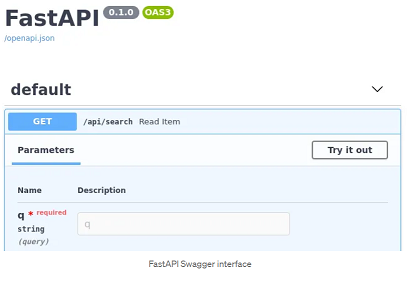

### Code example

- https://github.com/qdrant/demo-code-search

### Page search

- https://github.com/qdrant/page-search

### Coud documentation search

- https://github.com/qdrant/demo-cloud-faq

### Product categorization demo

- https://github.com/qdrant/goods_categorization_demo

### Qdrant + Haystack

- https://github.com/qdrant/qdrant-haystack

### QA workshop

- https://github.com/qdrant/qdrant-qa-workshop

### Lightning app

- https://github.com/qdrant/lightning-wine-reviews

## Milvus

Milvus uses TypeScript to interact with the DB..

- https://milvus.io/milvus-demos/
- https://github.com/milvus-io/milvus-demo-video-search
- https://github.com/milvus-io/milvus-demo-image-search

## Other demos

- https://github.com/DmitryKey/bert-solr-search